In [ ]:
# Creation of the region-specific masks using Freesurfer's Binarize

### Masks for hippocampus and caudate using FS aparc+aseg

In [2]:
import nipype.pipeline as pe
import nipype.interfaces.io as nio
import os
import nipype.interfaces.freesurfer as fs
from nipype import IdentityInterface


subjects_dir = '/home/data/madlab/surfaces/wmaze'
work_dir = '/scratch/madlab/wmaze/regions_workdir'
sink_dir = '/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask'

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021', 
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

wf = pe.Workflow(name = 'wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(IdentityInterface(fields = ['subject_id'], 
                                          mandatory_inputs = True),
                        name = 'subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

info = dict(ref_epi_file = [['subject_id']],
            bbreg_xfm = [['subject_id']],
            aparc_aseg = [['subject_id']])

# Node: Datagrabber
datasource = pe.Node(nio.DataGrabber(infields = ['subject_id'],
                                     outfields = info.keys()),
                     name = 'datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file = 'data/mri/wmaze/preproc/%s/ref/*.nii.gz',
                                        bbreg_xfm = 'data/mri/wmaze/preproc/%s/bbreg/_fs_register0/*.dat',
                                        aparc_aseg = 'surfaces/wmaze/%s/mri/aparc+aseg.mgz')
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

#### subj_iterable (subject_id) ----> datasource (subject_id)


# MapNode: Create binarized ROI masks
anat_mask = pe.MapNode(fs.Binarize(),
                       iterfield = ['match', 'binary_file'], 
                       name = 'anat_mask')
anat_mask.inputs.match = [[17],[53], #hippocampus
                          [12], [51]] #putamen
                          
anat_mask.inputs.binary_file = ['lh-hippocampus.nii.gz','rh-hippocampus.nii.gz',
                                'lh-putamen.nii.gz', 'rh-putamen.nii.gz']
wf.connect(datasource, 'aparc_aseg', anat_mask, 'in_file')

#### datasource (aparc_aseg) ----> anat_mask (in_file)


# MapNode: Transform the masks to 1st volume of 1st run (EPI space)
anatmask_xfm = pe.MapNode(fs.ApplyVolTransform(inverse = True,
                                               interp = 'nearest'),
                          iterfield = ['target_file'],
                          name = 'anatmask_xfm')
anatmask_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', anatmask_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', anatmask_xfm, 'reg_file')
wf.connect(anat_mask, 'binary_file', anatmask_xfm, 'target_file')

#### datasource (ref_epi_file) ----> anatmask_xfm (source_file)
#### datasource (bbreg_xfm) ----> anatmask_xfm (reg_file)
#### datasource (binary_file) ----> anatmask_xfm (target_file)


# Node: Datasink
sinker = pe.Node(nio.DataSink(infields = None),
                 name = "sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(anatmask_xfm, 'transformed_file', sinker, 'anat_masks')

#### anatmask_xfm (transformed_file) ----> sinker (anat_masks)

wf.run(plugin = 'LSF', plugin_args = {'bsub_args': '-q PQ_madlab'})

171020-22:09:00,874 workflow INFO:
	 ['check', 'execution', 'logging']
171020-22:09:01,342 workflow INFO:
	 Running in parallel.
171020-22:09:01,442 workflow INFO:
	 Pending[0] Submitting[20] jobs Slots[inf]
171020-22:09:01,449 workflow INFO:
	 Submitting: datasource.a06 ID: 0
171020-22:09:01,631 workflow INFO:
	 Finished submitting: datasource.a06 ID: 0
171020-22:09:01,637 workflow INFO:
	 Submitting: datasource.a14 ID: 1
171020-22:09:01,739 workflow INFO:
	 Finished submitting: datasource.a14 ID: 1
171020-22:09:01,745 workflow INFO:
	 Submitting: datasource.a11 ID: 3
171020-22:09:01,848 workflow INFO:
	 Finished submitting: datasource.a11 ID: 3
171020-22:09:01,855 workflow INFO:
	 Submitting: datasource.a00 ID: 5
171020-22:09:01,965 workflow INFO:
	 Finished submitting: datasource.a00 ID: 5
171020-22:09:01,971 workflow INFO:
	 Submitting: datasource.a10 ID: 9
171020-22:09:02,235 workflow INFO:
	 Finished submitting: datasource.a10 ID: 9
171020-22:09:02,242 workflow INFO:
	 Submitting

### Use Glob to grab all newly created anatomy masks and 2nd lvl cope files

In [21]:
from glob import glob

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(mask_filenames_glob)

    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/model4/' + SID + '/fixedfx/cope_*')
    cope_files.append(subjcopes_glob)
    if len(cope_files[-1]) == 0:
        print(SID)

## Cell to double-check the array indexing

In [22]:
print 'left hippocampus'
print(mask_filenames[0][0]) #lh-hippocampus
print 'left caudate'
print(mask_filenames[0][1]) #lh-caudate
print 'right caudate'
print(mask_filenames[0][2]) #rh-caudate
print 'right hippocampus'
print(mask_filenames[0][3]) #rh-hippocamus
print 'left putamen'
print(mask_filenames[0][4]) #lh-putamen
print 'right putamen'
print(mask_filenames[0][5]) #rh-putamen

print '-----'

print 'A_before_B_corr'
print(cope_files[0][0]) #A_before_B_corr
print 'A_before_B_incorr'
print(cope_files[0][1]) #A_before_B_incorr
print 'C_before_B_corr'
print(cope_files[0][2]) #C_before_B_corr
print 'C_before_B_incorr'
print(cope_files[0][3]) #C_before_B_incorr
print 'all_A_and_C'
print(cope_files[0][4]) #all_A_and_C
print 'all_remaining'
print(cope_files[0][5]) #all_remaining
print 'AB_corr_vs_AB_incorr'
print(cope_files[0][6]) #AB_corr_vs_AB_incorr
print 'AB_incorr_vs_AB_corr'
print(cope_files[0][7]) #AB_incorr_vs_AB_corr
print'CB_corr_vs_CB_incorr'
print(cope_files[0][8]) #CB_corr_vs_CB_incorr
print 'CB_incorr_vs_CB_corr'
print(cope_files[0][9]) #CB_incorr_vs_CB_corr
print 'AC_corr_vs_AC_incorr'
print(cope_files[0][10]) #AC_corr_vs_AC_incorr
print 'AC_incorr_vs_AC_corr'
print(cope_files[0][11]) #AC_incorr_vs_AC_corr


for i in cope_files:
    print(len(i))


left hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz
left caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh_caudate_anat_mask_warped.nii.gz
right caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/rh_caudate_anat_mask_warped.nii.gz
right hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm1/rh-hippocampus_warped.nii.gz
left putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm2/lh-putamen_warped.nii.gz
right putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm3/rh-putamen_warped.nii.gz
-----
A_before_B_corr
/home/data/madlab/dat

### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [23]:
import nibabel as nb
import pandas as pd
import numpy as np


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lhhp_A_before_B_corr':[], 'rhhp_A_before_B_corr':[], 
            'lhhp_A_before_B_incorr':[], 'rhhp_A_before_B_incorr':[],
            'lhhp_C_before_B_corr':[], 'rhhp_C_before_B_corr':[], 
            'lhhp_C_before_B_incorr':[], 'rhhp_C_before_B_incorr':[],
            'lhhp_all_A_and_C':[], 'rhhp_all_A_and_C':[],
            'lhhp_all_remaining':[], 'rhhp_all_remaining':[],
            'lhhp_AB_corr_vs_AB_incorr':[], 'rhhp_AB_corr_vs_AB_incorr':[], 
            'lhhp_AB_incorr_vs_AB_corr':[], 'rhhp_AB_incorr_vs_AB_corr':[],
            'lhhp_CB_corr_vs_CB_incorr':[], 'rhhp_CB_corr_vs_CB_incorr':[], 
            'lhhp_CB_incorr_vs_CB_corr':[], 'rhhp_CB_incorr_vs_CB_corr':[],
            'lhhp_AC_corr_vs_AC_incorr':[], 'rhhp_AC_corr_vs_AC_incorr':[], 
            'lhhp_AC_incorr_vs_AC_corr':[], 'rhhp_AC_incorr_vs_AC_corr':[],
            
            'lhcaudate_A_before_B_corr':[], 'rhcaudate_A_before_B_corr':[], 
            'lhcaudate_A_before_B_incorr':[], 'rhcaudate_A_before_B_incorr':[],
            'lhcaudate_C_before_B_corr':[], 'rhcaudate_C_before_B_corr':[], 
            'lhcaudate_C_before_B_incorr':[], 'rhcaudate_C_before_B_incorr':[],
            'lhcaudate_all_A_and_C':[], 'rhcaudate_all_A_and_C':[],
            'lhcaudate_all_remaining':[], 'rhcaudate_all_remaining':[],
            'lhcaudate_AB_corr_vs_AB_incorr':[], 'rhcaudate_AB_corr_vs_AB_incorr':[], 
            'lhcaudate_AB_incorr_vs_AB_corr':[], 'rhcaudate_AB_incorr_vs_AB_corr':[],
            'lhcaudate_CB_corr_vs_CB_incorr':[], 'rhcaudate_CB_corr_vs_CB_incorr':[], 
            'lhcaudate_CB_incorr_vs_CB_corr':[], 'rhcaudate_CB_incorr_vs_CB_corr':[],
            'lhcaudate_AC_corr_vs_AC_incorr':[], 'rhcaudate_AC_corr_vs_AC_incorr':[], 
            'lhcaudate_AC_incorr_vs_AC_corr':[], 'rhcaudate_AC_incorr_vs_AC_corr':[],
            
            'lhputamen_A_before_B_corr':[], 'rhputamen_A_before_B_corr':[], 
            'lhputamen_A_before_B_incorr':[], 'rhputamen_A_before_B_incorr':[],
            'lhputamen_C_before_B_corr':[], 'rhputamen_C_before_B_corr':[], 
            'lhputamen_C_before_B_incorr':[], 'rhputamen_C_before_B_incorr':[],
            'lhputamen_all_A_and_C':[], 'rhputamen_all_A_and_C':[],
            'lhputamen_all_remaining':[], 'rhputamen_all_remaining':[],
            'lhputamen_AB_corr_vs_AB_incorr':[], 'rhputamen_AB_corr_vs_AB_incorr':[], 
            'lhputamen_AB_incorr_vs_AB_corr':[], 'rhputamen_AB_incorr_vs_AB_corr':[],
            'lhputamen_CB_corr_vs_CB_incorr':[], 'rhputamen_CB_corr_vs_CB_incorr':[], 
            'lhputamen_CB_incorr_vs_CB_corr':[], 'rhputamen_CB_incorr_vs_CB_corr':[],
            'lhputamen_AC_corr_vs_AC_incorr':[], 'rhputamen_AC_corr_vs_AC_incorr':[], 
            'lhputamen_AC_incorr_vs_AC_corr':[], 'rhputamen_AC_incorr_vs_AC_corr':[]}


# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][3])
    lh_caudate_img = nb.load(mask_filenames[i][1])
    rh_caudate_img = nb.load(mask_filenames[i][2])
    lh_putamen_img = nb.load(mask_filenames[i][4])
    rh_putamen_img = nb.load(mask_filenames[i][5])

    
    #Load copes for individual trial types
    A_before_B_corr_img = nb.load(cope_files[i][0])
    A_before_B_incorr_img = nb.load(cope_files[i][1])
    C_before_B_corr_img = nb.load(cope_files[i][2])
    C_before_B_incorr_img = nb.load(cope_files[i][3])
    all_A_and_C_img = nb.load(cope_files[i][4])
    all_remaining_img = nb.load(cope_files[i][5])
    AB_corr_vs_AB_incorr_img = nb.load(cope_files[i][6])
    AB_incorr_vs_AB_corr_img = nb.load(cope_files[i][7])
    CB_corr_vs_CB_incorr_img = nb.load(cope_files[i][8])
    CB_incorr_vs_CB_corr_img = nb.load(cope_files[i][9])
    AC_corr_vs_AC_incorr_img = nb.load(cope_files[i][10])
    AC_incorr_vs_AC_corr_img = nb.load(cope_files[i][11])
    
    
    ########################
    ### Left Hippocampus ###
    ########################
    
    # A_before_B_corr
    lh_hp_A_before_B_corr_data = A_before_B_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_A_before_B_corr'].append(np.mean(lh_hp_A_before_B_corr_data))
    
    # A_before_B_incorr
    lh_hp_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_A_before_B_incorr'].append(np.mean(lh_hp_A_before_B_incorr_data))
    
    # C_before_B_corr
    lh_hp_C_before_B_corr_data = C_before_B_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_C_before_B_corr'].append(np.mean(lh_hp_C_before_B_corr_data))
    
    # C_before_B_incorr
    lh_hp_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_C_before_B_incorr'].append(np.mean(lh_hp_C_before_B_incorr_data))
    
    # all_A_and_C
    lh_hp_all_A_and_C_data = all_A_and_C_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_A_and_C'].append(np.mean(lh_hp_all_A_and_C_data))    
    
    # all_remaining
    lh_hp_all_remaining_data = all_remaining_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_remaining'].append(np.mean(lh_hp_all_remaining_data))
       
    # AB_corr_vs_AB_incorr
    lh_hp_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AB_corr_vs_AB_incorr'].append(np.mean(lh_hp_AB_corr_vs_AB_incorr_data)) 
    
    # AB_incorr_vs_AB_corr
    lh_hp_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AB_incorr_vs_AB_corr'].append(np.mean(lh_hp_AB_incorr_vs_AB_corr_data)) 
    
    # CB_corr_vs_CB_incorr
    lh_hp_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_CB_corr_vs_CB_incorr'].append(np.mean(lh_hp_CB_corr_vs_CB_incorr_data)) 
    
    # CB_incorr_vs_CB_corr
    lh_hp_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_CB_incorr_vs_CB_corr'].append(np.mean(lh_hp_CB_incorr_vs_CB_corr_data)) 
    
    # AC_corr_vs_AC_incorr
    lh_hp_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AC_corr_vs_AC_incorr'].append(np.mean(lh_hp_AC_corr_vs_AC_incorr_data)) 
    
    # AC_incorr_vs_AC_corr
    lh_hp_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AC_incorr_vs_AC_corr'].append(np.mean(lh_hp_AC_incorr_vs_AC_corr_data)) 
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # A_before_B_corr
    rh_hp_A_before_B_corr_data = A_before_B_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_A_before_B_corr'].append(np.mean(rh_hp_A_before_B_corr_data))

    # A_before_B_incorr
    rh_hp_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_A_before_B_incorr'].append(np.mean(rh_hp_A_before_B_incorr_data))

    # C_before_B_corr
    rh_hp_C_before_B_corr_data = C_before_B_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_C_before_B_corr'].append(np.mean(rh_hp_C_before_B_corr_data))

    # C_before_B_incorr
    rh_hp_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_C_before_B_incorr'].append(np.mean(rh_hp_C_before_B_incorr_data))
    
    # all_A_and_C
    rh_hp_all_A_and_C_data = all_A_and_C_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_A_and_C'].append(np.mean(rh_hp_all_A_and_C_data))

    # all_remaining
    rh_hp_all_remaining_data = all_remaining_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_remaining'].append(np.mean(rh_hp_all_remaining_data))

    # AB_corr_vs_AB_incorr
    rh_hp_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AB_corr_vs_AB_incorr'].append(np.mean(rh_hp_AB_corr_vs_AB_incorr_data)) 

    # AB_incorr_vs_AB_corr
    rh_hp_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AB_incorr_vs_AB_corr'].append(np.mean(rh_hp_AB_incorr_vs_AB_corr_data)) 

    # CB_corr_vs_CB_incorr
    rh_hp_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_CB_corr_vs_CB_incorr'].append(np.mean(rh_hp_CB_corr_vs_CB_incorr_data)) 

    # CB_incorr_vs_CB_corr
    rh_hp_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_CB_incorr_vs_CB_corr'].append(np.mean(rh_hp_CB_incorr_vs_CB_corr_data)) 

    # AC_corr_vs_AC_incorr
    rh_hp_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AC_corr_vs_AC_incorr'].append(np.mean(rh_hp_AC_corr_vs_AC_incorr_data)) 

    # AC_incorr_vs_AC_corr
    rh_hp_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AC_incorr_vs_AC_corr'].append(np.mean(rh_hp_AC_incorr_vs_AC_corr_data))
    
    
    ####################
    ### Left Caudate ###
    ####################
    
    # A_before_B_corr
    lh_caudate_A_before_B_corr_data = A_before_B_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_A_before_B_corr'].append(np.mean(lh_caudate_A_before_B_corr_data))
    
    # A_before_B_incorr
    lh_caudate_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_A_before_B_incorr'].append(np.mean(lh_caudate_A_before_B_incorr_data))
    
    # C_before_B_corr
    lh_caudate_C_before_B_corr_data = C_before_B_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_C_before_B_corr'].append(np.mean(lh_caudate_C_before_B_corr_data))
    
    # C_before_B_incorr
    lh_caudate_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_C_before_B_incorr'].append(np.mean(lh_caudate_C_before_B_incorr_data))
    
    # all_A_and_C
    lh_caudate_all_A_and_C_data = all_A_and_C_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_A_and_C'].append(np.mean(lh_caudate_all_A_and_C_data))
    
    # all_remaining
    lh_caudate_all_remaining_data = all_remaining_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_remaining'].append(np.mean(lh_caudate_all_remaining_data))
       
    # AB_corr_vs_AB_incorr
    lh_caudate_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_AB_corr_vs_AB_incorr'].append(np.mean(lh_caudate_AB_corr_vs_AB_incorr_data)) 
    
    # AB_incorr_vs_AB_corr
    lh_caudate_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_AB_incorr_vs_AB_corr'].append(np.mean(lh_caudate_AB_incorr_vs_AB_corr_data)) 
    
    # CB_corr_vs_CB_incorr
    lh_caudate_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_CB_corr_vs_CB_incorr'].append(np.mean(lh_caudate_CB_corr_vs_CB_incorr_data)) 
    
    # CB_incorr_vs_CB_corr
    lh_caudate_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_CB_incorr_vs_CB_corr'].append(np.mean(lh_caudate_CB_incorr_vs_CB_corr_data)) 
    
    # AC_corr_vs_AC_incorr
    lh_caudate_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_AC_corr_vs_AC_incorr'].append(np.mean(lh_caudate_AC_corr_vs_AC_incorr_data)) 
    
    # AC_incorr_vs_AC_corr
    lh_caudate_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_AC_incorr_vs_AC_corr'].append(np.mean(lh_caudate_AC_incorr_vs_AC_corr_data)) 
    
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # A_before_B_corr
    rh_caudate_A_before_B_corr_data = A_before_B_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_A_before_B_corr'].append(np.mean(rh_caudate_A_before_B_corr_data))

    # A_before_B_incorr
    rh_caudate_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_A_before_B_incorr'].append(np.mean(rh_caudate_A_before_B_incorr_data))

    # C_before_B_corr
    rh_caudate_C_before_B_corr_data = C_before_B_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_C_before_B_corr'].append(np.mean(rh_caudate_C_before_B_corr_data))

    # C_before_B_incorr
    rh_caudate_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_C_before_B_incorr'].append(np.mean(rh_caudate_C_before_B_incorr_data))
    
    # all_A_and_C
    rh_caudate_all_A_and_C_data = all_A_and_C_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_A_and_C'].append(np.mean(rh_caudate_all_A_and_C_data))
    
    # all_remaining
    rh_caudate_all_remaining_data = all_remaining_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_remaining'].append(np.mean(rh_caudate_all_remaining_data))

    # AB_corr_vs_AB_incorr
    rh_caudate_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_AB_corr_vs_AB_incorr'].append(np.mean(rh_caudate_AB_corr_vs_AB_incorr_data)) 

    # AB_incorr_vs_AB_corr
    rh_caudate_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_AB_incorr_vs_AB_corr'].append(np.mean(rh_caudate_AB_incorr_vs_AB_corr_data)) 

    # CB_corr_vs_CB_incorr
    rh_caudate_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_CB_corr_vs_CB_incorr'].append(np.mean(rh_caudate_CB_corr_vs_CB_incorr_data)) 

    # CB_incorr_vs_CB_corr
    rh_caudate_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_CB_incorr_vs_CB_corr'].append(np.mean(rh_caudate_CB_incorr_vs_CB_corr_data)) 

    # AC_corr_vs_AC_incorr
    rh_caudate_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_AC_corr_vs_AC_incorr'].append(np.mean(rh_caudate_AC_corr_vs_AC_incorr_data)) 

    # AC_incorr_vs_AC_corr
    rh_caudate_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_AC_incorr_vs_AC_corr'].append(np.mean(rh_caudate_AC_incorr_vs_AC_corr_data)) 
    
    
    ####################
    ### Left Putamen ###
    ####################
    # A_before_B_corr
    lh_putamen_A_before_B_corr_data = A_before_B_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_A_before_B_corr'].append(np.mean(lh_putamen_A_before_B_corr_data))
    
    # A_before_B_incorr
    lh_putamen_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_A_before_B_incorr'].append(np.mean(lh_putamen_A_before_B_incorr_data))
    
    # C_before_B_corr
    lh_putamen_C_before_B_corr_data = C_before_B_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_C_before_B_corr'].append(np.mean(lh_putamen_C_before_B_corr_data))
    
    # C_before_B_incorr
    lh_putamen_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_C_before_B_incorr'].append(np.mean(lh_putamen_C_before_B_incorr_data))
    
    # all_A_and_C
    lh_putamen_all_A_and_C_data = all_A_and_C_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_A_and_C'].append(np.mean(lh_putamen_all_A_and_C_data))
    
    # all_remaining
    lh_putamen_all_remaining_data = all_remaining_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_remaining'].append(np.mean(lh_putamen_all_remaining_data))
       
    # AB_corr_vs_AB_incorr
    lh_putamen_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_AB_corr_vs_AB_incorr'].append(np.mean(lh_putamen_AB_corr_vs_AB_incorr_data)) 
    
    # AB_incorr_vs_AB_corr
    lh_putamen_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_AB_incorr_vs_AB_corr'].append(np.mean(lh_putamen_AB_incorr_vs_AB_corr_data)) 
    
    # CB_corr_vs_CB_incorr
    lh_putamen_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_CB_corr_vs_CB_incorr'].append(np.mean(lh_putamen_CB_corr_vs_CB_incorr_data)) 
    
    # CB_incorr_vs_CB_corr
    lh_putamen_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_CB_incorr_vs_CB_corr'].append(np.mean(lh_putamen_CB_incorr_vs_CB_corr_data)) 
    
    # AC_corr_vs_AC_incorr
    lh_putamen_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_AC_corr_vs_AC_incorr'].append(np.mean(lh_putamen_AC_corr_vs_AC_incorr_data)) 
    
    # AC_incorr_vs_AC_corr
    lh_putamen_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_AC_incorr_vs_AC_corr'].append(np.mean(lh_putamen_AC_incorr_vs_AC_corr_data)) 
    
    
    #####################
    ### Right Putamen ###
    #####################
    
    # A_before_B_corr
    rh_putamen_A_before_B_corr_data = A_before_B_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_A_before_B_corr'].append(np.mean(rh_putamen_A_before_B_corr_data))

    # A_before_B_incorr
    rh_putamen_A_before_B_incorr_data = A_before_B_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_A_before_B_incorr'].append(np.mean(rh_putamen_A_before_B_incorr_data))

    # C_before_B_corr
    rh_putamen_C_before_B_corr_data = C_before_B_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_C_before_B_corr'].append(np.mean(rh_putamen_C_before_B_corr_data))

    # C_before_B_incorr
    rh_putamen_C_before_B_incorr_data = C_before_B_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_C_before_B_incorr'].append(np.mean(rh_putamen_C_before_B_incorr_data))
    
    # all_A_and_C
    rh_putamen_all_A_and_C_data = all_A_and_C_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_A_and_C'].append(np.mean(rh_putamen_all_A_and_C_data))

    # all_remaining
    rh_putamen_all_remaining_data = all_remaining_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_remaining'].append(np.mean(rh_putamen_all_remaining_data))

    # AB_corr_vs_AB_incorr
    rh_putamen_AB_corr_vs_AB_incorr_data = AB_corr_vs_AB_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_AB_corr_vs_AB_incorr'].append(np.mean(rh_putamen_AB_corr_vs_AB_incorr_data)) 

    # AB_incorr_vs_AB_corr
    rh_putamen_AB_incorr_vs_AB_corr_data = AB_incorr_vs_AB_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_AB_incorr_vs_AB_corr'].append(np.mean(rh_putamen_AB_incorr_vs_AB_corr_data)) 

    # CB_corr_vs_CB_incorr
    rh_putamen_CB_corr_vs_CB_incorr_data = CB_corr_vs_CB_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_CB_corr_vs_CB_incorr'].append(np.mean(rh_putamen_CB_corr_vs_CB_incorr_data)) 

    # CB_incorr_vs_CB_corr
    rh_putamen_CB_incorr_vs_CB_corr_data = CB_incorr_vs_CB_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_CB_incorr_vs_CB_corr'].append(np.mean(rh_putamen_CB_incorr_vs_CB_corr_data)) 

    # AC_corr_vs_AC_incorr
    rh_putamen_AC_corr_vs_AC_incorr_data = AC_corr_vs_AC_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_AC_corr_vs_AC_incorr'].append(np.mean(rh_putamen_AC_corr_vs_AC_incorr_data)) 

    # AC_incorr_vs_AC_corr
    rh_putamen_AC_incorr_vs_AC_corr_data = AC_incorr_vs_AC_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_AC_incorr_vs_AC_corr'].append(np.mean(rh_putamen_AC_incorr_vs_AC_corr_data)) 
    
    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [26]:
#Hippocampus average for each trial type
all_data_df['hp_A_before_B_corr'] = (all_data_df['lhhp_A_before_B_corr'] + 
                                     all_data_df['rhhp_A_before_B_corr'])/2.
all_data_df['hp_A_before_B_incorr'] = (all_data_df['lhhp_A_before_B_incorr'] + 
                                       all_data_df['rhhp_A_before_B_incorr'])/2.
all_data_df['hp_C_before_B_corr'] = (all_data_df['lhhp_C_before_B_corr'] + 
                                     all_data_df['rhhp_C_before_B_corr'])/2.
all_data_df['hp_C_before_B_incorr'] = (all_data_df['lhhp_C_before_B_incorr'] + 
                                       all_data_df['rhhp_C_before_B_incorr'])/2.
all_data_df['hp_all_A_and_C'] = (all_data_df['lhhp_all_A_and_C'] + 
                                 all_data_df['rhhp_all_A_and_C'])/2.
all_data_df['hp_all_remaining'] = (all_data_df['lhhp_all_remaining'] + 
                                 all_data_df['rhhp_all_remaining'])/2.
all_data_df['hp_AB_corr_vs_AB_incorr'] = (all_data_df['lhhp_AB_corr_vs_AB_incorr'] + 
                                             all_data_df['rhhp_AB_corr_vs_AB_incorr'])/2.
all_data_df['hp_AB_incorr_vs_AB_corr'] = (all_data_df['lhhp_AB_incorr_vs_AB_corr'] + 
                                             all_data_df['rhhp_AB_incorr_vs_AB_corr'])/2.
all_data_df['hp_CB_corr_vs_CB_incorr'] = (all_data_df['lhhp_CB_corr_vs_CB_incorr'] + 
                                             all_data_df['rhhp_CB_corr_vs_CB_incorr'])/2.
all_data_df['hp_CB_incorr_vs_CB_corr'] = (all_data_df['lhhp_CB_incorr_vs_CB_corr'] + 
                                             all_data_df['rhhp_CB_incorr_vs_CB_corr'])/2.
all_data_df['hp_AC_corr_vs_AC_incorr'] = (all_data_df['lhhp_AC_corr_vs_AC_incorr'] + 
                                             all_data_df['rhhp_AC_corr_vs_AC_incorr'])/2.
all_data_df['hp_AC_incorr_vs_AC_corr'] = (all_data_df['lhhp_AC_incorr_vs_AC_corr'] + 
                                             all_data_df['rhhp_AC_incorr_vs_AC_corr'])/2.

#Caudate average for each trial type
all_data_df['caudate_A_before_B_corr'] = (all_data_df['lhcaudate_A_before_B_corr'] + 
                                          all_data_df['rhcaudate_A_before_B_corr'])/2.
all_data_df['caudate_A_before_B_incorr'] = (all_data_df['lhcaudate_A_before_B_incorr'] + 
                                            all_data_df['rhcaudate_A_before_B_incorr'])/2.
all_data_df['caudate_C_before_B_corr'] = (all_data_df['lhcaudate_C_before_B_corr'] + 
                                          all_data_df['rhcaudate_C_before_B_corr'])/2.
all_data_df['caudate_C_before_B_incorr'] = (all_data_df['lhcaudate_C_before_B_incorr'] + 
                                            all_data_df['rhcaudate_C_before_B_incorr'])/2.
all_data_df['caudate_all_A_and_C'] = (all_data_df['lhcaudate_all_A_and_C'] + 
                                      all_data_df['rhcaudate_all_A_and_C'])/2.
all_data_df['caudate_all_remaining'] = (all_data_df['lhcaudate_all_remaining'] + 
                                      all_data_df['rhcaudate_all_remaining'])/2.
all_data_df['caudate_AB_corr_vs_AB_incorr'] = (all_data_df['lhcaudate_AB_corr_vs_AB_incorr'] + 
                                                  all_data_df['rhcaudate_AB_corr_vs_AB_incorr'])/2.
all_data_df['caudate_AB_incorr_vs_AB_corr'] = (all_data_df['lhcaudate_AB_incorr_vs_AB_corr'] + 
                                                  all_data_df['rhcaudate_AB_incorr_vs_AB_corr'])/2.
all_data_df['caudate_CB_corr_vs_CB_incorr'] = (all_data_df['lhcaudate_CB_corr_vs_CB_incorr'] + 
                                                  all_data_df['rhcaudate_CB_corr_vs_CB_incorr'])/2.
all_data_df['caudate_CB_incorr_vs_CB_corr'] = (all_data_df['lhcaudate_CB_incorr_vs_CB_corr'] + 
                                                  all_data_df['rhcaudate_CB_incorr_vs_CB_corr'])/2.
all_data_df['caudate_AC_corr_vs_AC_incorr'] = (all_data_df['lhcaudate_AC_corr_vs_AC_incorr'] + 
                                                  all_data_df['rhcaudate_AC_corr_vs_AC_incorr'])/2.
all_data_df['caudate_AC_incorr_vs_AC_corr'] = (all_data_df['lhcaudate_AC_incorr_vs_AC_corr'] + 
                                                  all_data_df['rhcaudate_AC_incorr_vs_AC_corr'])/2.

#Putamen average for each trial type
all_data_df['putamen_A_before_B_corr'] = (all_data_df['lhputamen_A_before_B_corr'] + 
                                          all_data_df['rhputamen_A_before_B_corr'])/2.
all_data_df['putamen_A_before_B_incorr'] = (all_data_df['lhputamen_A_before_B_incorr'] + 
                                            all_data_df['rhputamen_A_before_B_incorr'])/2.
all_data_df['putamen_C_before_B_corr'] = (all_data_df['lhputamen_C_before_B_corr'] + 
                                          all_data_df['rhputamen_C_before_B_corr'])/2.
all_data_df['putamen_C_before_B_incorr'] = (all_data_df['lhputamen_C_before_B_incorr'] + 
                                            all_data_df['rhputamen_C_before_B_incorr'])/2.
all_data_df['putamen_all_A_and_C'] = (all_data_df['lhputamen_all_A_and_C'] + 
                                      all_data_df['rhputamen_all_A_and_C'])/2.
all_data_df['putamen_all_remaining'] = (all_data_df['lhputamen_all_remaining'] + 
                                      all_data_df['rhputamen_all_remaining'])/2.
all_data_df['putamen_AB_corr_vs_AB_incorr'] = (all_data_df['lhputamen_AB_corr_vs_AB_incorr'] + 
                                                  all_data_df['rhputamen_AB_corr_vs_AB_incorr'])/2.
all_data_df['putamen_AB_incorr_vs_AB_corr'] = (all_data_df['lhputamen_AB_incorr_vs_AB_corr'] + 
                                                  all_data_df['rhputamen_AB_incorr_vs_AB_corr'])/2.
all_data_df['putamen_CB_corr_vs_CB_incorr'] = (all_data_df['lhputamen_CB_corr_vs_CB_incorr'] + 
                                                  all_data_df['rhputamen_CB_corr_vs_CB_incorr'])/2.
all_data_df['putamen_CB_incorr_vs_CB_corr'] = (all_data_df['lhputamen_CB_incorr_vs_CB_corr'] + 
                                                  all_data_df['rhputamen_CB_incorr_vs_CB_corr'])/2.
all_data_df['putamen_AC_corr_vs_AC_incorr'] = (all_data_df['lhputamen_AC_corr_vs_AC_incorr'] + 
                                                  all_data_df['rhputamen_AC_corr_vs_AC_incorr'])/2.
all_data_df['putamen_AC_incorr_vs_AC_corr'] = (all_data_df['lhputamen_AC_incorr_vs_AC_corr'] + 
                                                  all_data_df['rhputamen_AC_incorr_vs_AC_corr'])/2.

## Hippocampus Activation: Fixed vs. Conditional Trials

In [27]:
from scipy import stats

print 'A_before_B_corr mean'
print all_data_df['hp_A_before_B_corr'].mean()
print 'A_before_B_incorr'
print all_data_df['hp_A_before_B_incorr'].mean()
print 'C_before_B_corr'
print all_data_df['hp_C_before_B_corr'].mean()
print 'C_before_B_incorr'
print all_data_df['hp_C_before_B_incorr'].mean()



print 'T-test: Hippocampus A_before_B_corr vs. A_before_B_incorr'
print stats.ttest_rel(all_data_df['hp_A_before_B_corr'], all_data_df['hp_A_before_B_incorr'])
print 'T-test: Hippocampus C_before_B_corr vs. C_before_B_incorr'
print stats.ttest_rel(all_data_df['hp_C_before_B_corr'], all_data_df['hp_C_before_B_incorr'])

print 'ANOVA: Hippocampus A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr'
print stats.f_oneway(all_data_df['hp_A_before_B_corr'], all_data_df['hp_A_before_B_incorr'],
                     all_data_df['hp_C_before_B_corr'], all_data_df['hp_C_before_B_incorr'])

A_before_B_corr mean
-1.05387788131
A_before_B_incorr
-2.48306475058
C_before_B_corr
-1.23917401507
C_before_B_incorr
-2.00755308345
T-test: Hippocampus A_before_B_corr vs. A_before_B_incorr
Ttest_relResult(statistic=3.8766030673755805, pvalue=0.0010156573625270113)
T-test: Hippocampus C_before_B_corr vs. C_before_B_incorr
Ttest_relResult(statistic=2.0765731089704689, pvalue=0.051651093601226786)
ANOVA: Hippocampus A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr
F_onewayResult(statistic=2.1665712537256399, pvalue=0.098875715486124158)


### Hippocampus Activation: Fixed Before Correct vs. Incorrect Conditional Trials

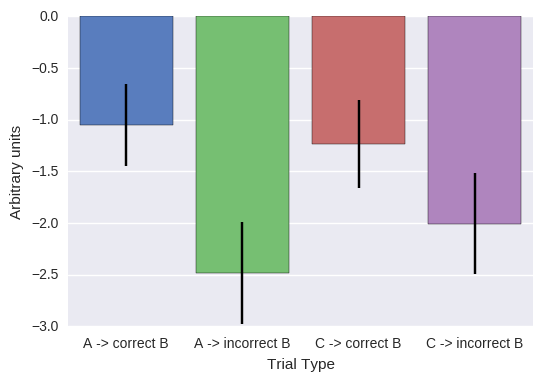

In [28]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['A -> correct B', 'A -> incorrect B', 'C -> correct B', 'C -> incorrect B']
#bar_colors = ['red', 'blue', 'green', 'orange']
hp_means_allsubjs = [all_data_df['hp_A_before_B_corr'].mean(), 
                     all_data_df['hp_A_before_B_incorr'].mean(), 
                     all_data_df['hp_C_before_B_corr'].mean(),
                     all_data_df['hp_C_before_B_incorr'].mean()]
hp_sem_allsubjs = [all_data_df['hp_A_before_B_corr'].std()/(np.sqrt(len(sids))), 
                   all_data_df['hp_A_before_B_incorr'].std()/(np.sqrt(len(sids))),
                   all_data_df['hp_C_before_B_corr'].std()/(np.sqrt(len(sids))),
                   all_data_df['hp_C_before_B_incorr'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax = sns.barplot(ind, hp_means_allsubjs, yerr = hp_sem_allsubjs, ecolor = 'black')


ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_xlabel("Trial Type")
#ax.set_title("Hippocampal Activation")

plt.show()

In [29]:
from scipy import stats

print 'A_before_B_corr mean'
print all_data_df['hp_AC_corr_vs_AC_incorr'].mean()
print 'A_before_B_incorr'
print all_data_df['hp_AC_incorr_vs_AC_corr'].mean()


print 'T-test: Hippocampus hp_AC_corr_vs_AC_incorr vs. hp_AC_incorr_vs_AC_corr'
print stats.ttest_rel(all_data_df['hp_AC_corr_vs_AC_incorr'], all_data_df['hp_AC_incorr_vs_AC_corr'])

A_before_B_corr mean
1.63710764372
A_before_B_incorr
-1.63710764372
T-test: Hippocampus hp_AC_corr_vs_AC_incorr vs. hp_AC_incorr_vs_AC_corr
Ttest_relResult(statistic=5.7053490004835092, pvalue=1.6873305390291823e-05)


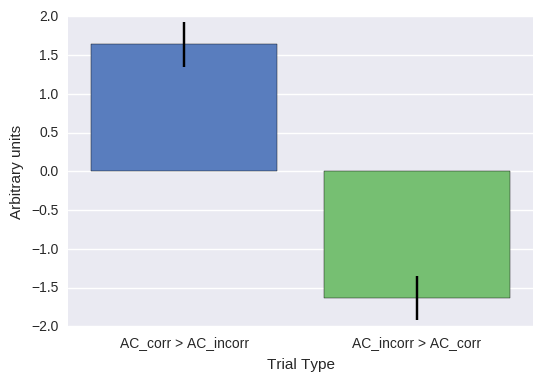

In [30]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 2
conditions = ['AC_corr > AC_incorr', 'AC_incorr > AC_corr']
#bar_colors = ['red', 'blue', 'green', 'orange']
hp_means_allsubjs = [all_data_df['hp_AC_corr_vs_AC_incorr'].mean(), 
                     all_data_df['hp_AC_incorr_vs_AC_corr'].mean()]
hp_sem_allsubjs = [all_data_df['hp_AC_corr_vs_AC_incorr'].std()/(np.sqrt(len(sids))), 
                   all_data_df['hp_AC_incorr_vs_AC_corr'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax = sns.barplot(ind, hp_means_allsubjs, yerr = hp_sem_allsubjs, ecolor = 'black')


ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_xlabel("Trial Type")
#ax.set_title("Hippocampal Activation")

plt.show()

### Caudate Stats

In [31]:
from scipy import stats

print 'A_before_B_corr'
print all_data_df['caudate_A_before_B_corr'].mean()
print 'A_before_B_incorr'
print all_data_df['caudate_A_before_B_incorr'].mean()
print 'C_before_B_corr'
print all_data_df['caudate_C_before_B_corr'].mean()
print 'C_before_B_incorr'
print all_data_df['caudate_C_before_B_incorr'].mean()



print 'T-test: Caudate A_before_B_corr vs. A_before_B_incorr'
print stats.ttest_rel(all_data_df['caudate_A_before_B_corr'], all_data_df['caudate_A_before_B_incorr'])
print 'T-test: Caudate C_before_B_corr vs. C_before_B_incorr'
print stats.ttest_rel(all_data_df['caudate_C_before_B_corr'], all_data_df['caudate_C_before_B_incorr'])

print 'ANOVA: Caudate A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr'
print stats.f_oneway(all_data_df['caudate_A_before_B_corr'], all_data_df['caudate_A_before_B_incorr'],
                     all_data_df['caudate_C_before_B_corr'], all_data_df['caudate_C_before_B_incorr'])

A_before_B_corr
1.07816470806
A_before_B_incorr
1.07069980241
C_before_B_corr
0.513121899217
C_before_B_incorr
1.70058630556
T-test: Caudate A_before_B_corr vs. A_before_B_incorr
Ttest_relResult(statistic=0.017472005907943521, pvalue=0.98624223777712983)
T-test: Caudate C_before_B_corr vs. C_before_B_incorr
Ttest_relResult(statistic=-2.1880417643242298, pvalue=0.041365486852236767)
ANOVA: Caudate A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr
F_onewayResult(statistic=0.70102060033335367, pvalue=0.5543376703255658)


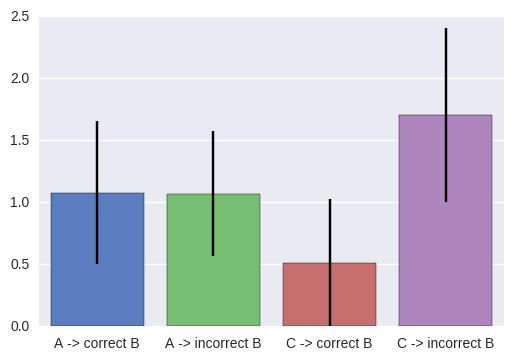

In [32]:
import matplotlib.pyplot as plt

N = 4
conditions = ['A -> correct B', 'A -> incorrect B', 'C -> correct B', 'C -> incorrect B']
bar_colors = ['red', 'blue', 'green', 'orange']
caudate_means_allsubjs = [all_data_df['caudate_A_before_B_corr'].mean(), 
                     all_data_df['caudate_A_before_B_incorr'].mean(), 
                     all_data_df['caudate_C_before_B_corr'].mean(),
                     all_data_df['caudate_C_before_B_incorr'].mean()]
caudate_sem_allsubjs = [all_data_df['caudate_A_before_B_corr'].std()/(np.sqrt(len(sids))), 
                   all_data_df['caudate_A_before_B_incorr'].std()/(np.sqrt(len(sids))),
                   all_data_df['caudate_C_before_B_corr'].std()/(np.sqrt(len(sids))),
                   all_data_df['caudate_C_before_B_incorr'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, caudate_means_allsubjs, yerr = caudate_sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylabel("Arbitrary units")
#ax.set_xlabel("Trial Type")
#ax.set_title("Caudate Activation")

plt.show()

### Putamen Stats

In [33]:
from scipy import stats

print 'A_before_B_corr'
print all_data_df['putamen_A_before_B_corr'].mean()
print 'A_before_B_incorr'
print all_data_df['putamen_A_before_B_incorr'].mean()
print 'C_before_B_corr'
print all_data_df['putamen_C_before_B_corr'].mean()
print 'C_before_B_incorr'
print all_data_df['putamen_C_before_B_incorr'].mean()



print 'T-test: putamen A_before_B_corr vs. A_before_B_incorr'
print stats.ttest_rel(all_data_df['putamen_A_before_B_corr'], all_data_df['putamen_A_before_B_incorr'])
print 'T-test: putamen C_before_B_corr vs. C_before_B_incorr'
print stats.ttest_rel(all_data_df['putamen_C_before_B_corr'], all_data_df['putamen_C_before_B_incorr'])

print 'ANOVA: putamen A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr'
print stats.f_oneway(all_data_df['putamen_A_before_B_corr'], all_data_df['putamen_A_before_B_incorr'],
                     all_data_df['putamen_C_before_B_corr'], all_data_df['putamen_C_before_B_incorr'])

A_before_B_corr
0.849087750167
A_before_B_incorr
-1.07803600011
C_before_B_corr
0.547809669562
C_before_B_incorr
0.195193843474
T-test: putamen A_before_B_corr vs. A_before_B_incorr
Ttest_relResult(statistic=4.7486586797884458, pvalue=0.0001397181576297663)
T-test: putamen C_before_B_corr vs. C_before_B_incorr
Ttest_relResult(statistic=0.65020097874580385, pvalue=0.52334725911015234)
ANOVA: putamen A_before_B_corr vs. A_before_B_incorr vs. C_before_B_corr vs.C_before_B_incorr
F_onewayResult(statistic=2.2309352585417082, pvalue=0.091413306200381239)


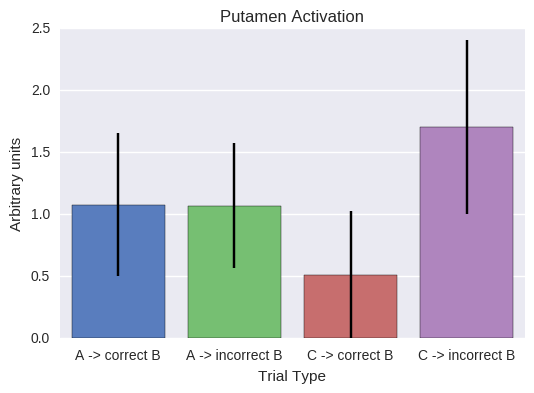

In [34]:
import matplotlib.pyplot as plt

N = 4
conditions = ['A -> correct B', 'A -> incorrect B', 'C -> correct B', 'C -> incorrect B']
bar_colors = ['red', 'blue', 'green', 'orange']
putamen_means_allsubjs = [all_data_df['putamen_A_before_B_corr'].mean(), 
                     all_data_df['putamen_A_before_B_incorr'].mean(), 
                     all_data_df['putamen_C_before_B_corr'].mean(),
                     all_data_df['putamen_C_before_B_incorr'].mean()]
putamen_sem_allsubjs = [all_data_df['putamen_A_before_B_corr'].std()/(np.sqrt(len(sids))), 
                   all_data_df['putamen_A_before_B_incorr'].std()/(np.sqrt(len(sids))),
                   all_data_df['putamen_C_before_B_corr'].std()/(np.sqrt(len(sids))),
                   all_data_df['putamen_C_before_B_incorr'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, caudate_means_allsubjs, yerr = caudate_sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_xlabel("Trial Type")
ax.set_title("Putamen Activation")

plt.show()

In [15]:
%matplotlib inline
from os.path import join
import numpy as np
import pandas as pd
from glob import glob
from pylab import *
import matplotlib.pyplot as plt

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 'WMAZE_007',
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 'WMAZE_017', 'WMAZE_018',
        'WMAZE_019', 'WMAZE_020', 'WMAZE_021', 'WMAZE_022', 'WMAZE_023', 'WMAZE_024',
        'WMAZE_026', 'WMAZE_027']


all_corr_B = []

for sub in subs:
    # Array containing path to behavior files
    sub_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/'.format(sub)
    # Array containing current sub's 6 behavior file runs
    dir_file = glob(join(sub_dir, '{0}_wmazebl_2015*.txt'.format(sub)))    
    # Sort current sub's txt files in order of run
    dir_file.sort() 
    
    
    data_run1 = pd.read_table(dir_file[0])
    data_run2 = pd.read_table(dir_file[1])
    data_run3 = pd.read_table(dir_file[2])
    data_run4 = pd.read_table(dir_file[3])
    data_run5 = pd.read_table(dir_file[4])
    data_run6 = pd.read_table(dir_file[5])
    
    all_runs = [data_run1, data_run2, data_run3, data_run4, data_run5, data_run6]
    
    data_set = pd.concat(all_runs)
     
    all_Bs = data_set.query('TrialType == "B"')
    corr_Bs = all_Bs['Correct']
    tot_corr_B = np.sum(corr_Bs)/240    
    
    
    all_corr_B.append(tot_corr_B)
    
print all_corr_B
print len(all_corr_B)

[0.79166666666666663, 0.84999999999999998, 0.7583333333333333, 0.79583333333333328, 0.73333333333333328, 0.69999999999999996, 0.70833333333333337, 0.69166666666666665, 0.53749999999999998, 0.71666666666666667, 0.67500000000000004, 0.78749999999999998, 0.79166666666666663, 0.84999999999999998, 0.7416666666666667, 0.625, 0.84583333333333333, 0.78333333333333333, 0.76249999999999996, 0.74583333333333335]
20


20
20


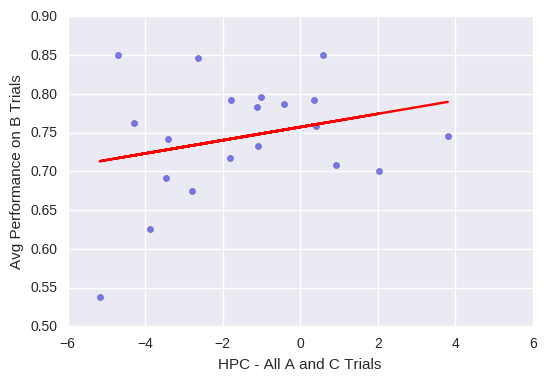

In [16]:
# Scatterplot

x = all_data_df['hp_all_A_and_C']
y = all_corr_B
print len(x)
print len(y)
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, fit[0] * x + fit[1], color = 'red')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_xlabel('HPC - All A and C Trials')
ax.set_ylabel('Avg Performance on B Trials')



In [17]:
import pandas as pd
corr_chart = {}
corr_chart['ac_hpc'] = all_data_df['hp_all_A_and_C']
corr_chart['b_per'] = all_corr_B
corr_chart_df = pd.DataFrame.from_dict(corr_chart)

In [18]:
corr_chart_df.corr()

,ac_hpc,b_per
ac_hpc,1.000000,0.263097
b_per,0.263097,1.000000


In [19]:
from scipy import stats

stats.pearsonr(all_data_df['hp_all_A_and_C'], all_corr_B)

(0.2630971213117046, 0.26240140480139684)